In [797]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report as report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import average_precision_score
import seaborn as sns
from sklearn.metrics import confusion_matrix as matrix
from sklearn.metrics import average_precision_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE)
import matplotlib.pyplot as plt

# Dataset1: http(contamination:0.0039)

## load train/test data

In [798]:
http_train=pd.read_csv('data/http_train.csv',sep=',')
http_test=pd.read_csv('data/http_test.csv',sep=',')

#train_raw_data = http_train.drop(http_train.index[0])
train_data = http_train.drop(http_train.columns[-1],axis='columns')
train_label = http_train.iloc[:,-1]

#test_raw_data = http_test.drop(http_test.index[0])
test_data = http_test.drop(http_test.columns[-1],axis='columns')
test_label = http_test.iloc[:,-1]

#train_data.head()
http_train.shape

(453998, 4)

452229
1769


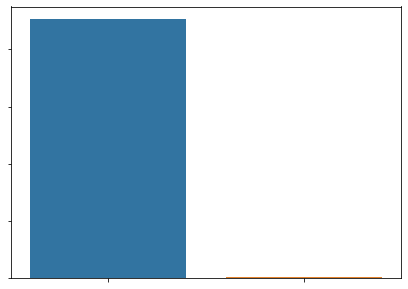

In [799]:
plt.figure(figsize=(7,5))
fig = sns.countplot(x="3", data=http_train) 
for p in fig.patches:
    height = p.get_height()
    print(height)
    fig.text(p.get_x()+p.get_width()/2., height + 0.5,height ,ha="center")

## build a model(isolation forest)

In [800]:
IF_model = IsolationForest(n_estimators=60,random_state=42,contamination=(0.003911734),n_jobs=-1,behaviour="new")
# param_grid = {'n_estimators': list(range(50, 300, 50)), 
#               'max_samples': list(range(200, 500, 20)), 
#               'contamination': [0.0040, 0.0050,0.0060,0.0070,0.0080,0.0090,0.010],
#                }
# #"'max_features':list"
# IF_model = GridSearchCV(IF_model, param_grid ,scoring="average_precision", cv=5)
IF_model.fit(train_data,train_label)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.003911734,
                max_features=1.0, max_samples='auto', n_estimators=60,
                n_jobs=-1, random_state=42, verbose=0, warm_start=False)

## calculate average precision

In [801]:
test_score=IF_model.decision_function(test_data)
print(test_score)
average_precision = average_precision_score(test_label, -test_score)
print('Average precision-recall score: {0:0.5f}'.format(
      average_precision))

[0.31367355 0.2821482  0.30755124 ... 0.29851435 0.34102049 0.28994197]
Average precision-recall score: 0.96971


## make predict

In [802]:
result_model=IF_model.predict(test_data)
#report_model=report(test_label,result_model,digits=5)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
#print(result_model)
report_model=report(test_label,result_model,digits=5)
matrix_model=matrix(test_label,result_model)
print(report_model)
print(matrix_model)

              precision    recall  f1-score   support

           0    0.99988   0.99990   0.99989    113058
           1    0.97494   0.96833   0.97162       442

    accuracy                        0.99978    113500
   macro avg    0.98741   0.98411   0.98576    113500
weighted avg    0.99978   0.99978   0.99978    113500

[[113047     11]
 [    14    428]]


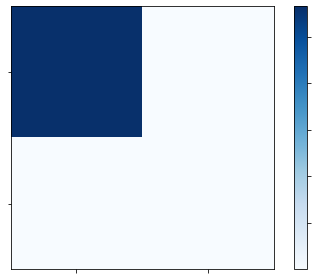

In [803]:
# Plot non-normalized confusion matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
class_names = [0,1]
plt.figure()
plot_confusion_matrix(matrix_model
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

## plot

isolation: f1=0.972 auc=0.807


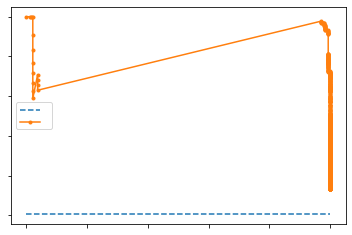

In [804]:
# predict probabilities
lr_probs = IF_model.score_samples(test_data)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# predict class values
result_model = IF_model.predict(test_data)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
lr_precision, lr_recall, _ = precision_recall_curve(test_label, -lr_probs)
lr_f1, lr_auc = f1_score(test_label, result_model), auc(lr_recall, lr_precision)
# summarize scores
print('isolation: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
out_lier = len(test_label[test_label==1]) / len(test_label)
plt.plot([0, 1], [out_lier, out_lier], linestyle='--', label='out_lier')
plt.plot(lr_recall, lr_precision, marker='.', label='isolation')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# Dataset2: Cardio (Contamination : 0.096)

## load train/test data

In [805]:
cardio_train=pd.read_csv('data/cardio_train.csv',sep=',')
cardio_test=pd.read_csv('data/cardio_test.csv',sep=',')

#train_raw_data = http_train.drop(http_train.index[0])
train_data = cardio_train.drop(cardio_train.columns[-1],axis='columns')
train_label = cardio_train.iloc[:,-1]

#test_raw_data = http_test.drop(http_test.index[0])
test_data = cardio_test.drop(cardio_test.columns[-1],axis='columns')
test_label = cardio_test.iloc[:,-1]

#train_data.head()
cardio_train.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.746331,0.674374,-0.203640,0.569296,-0.683598,-0.061401,-0.278295,1.161352,-0.862298,-0.420487,...,0.342006,-0.565334,-0.409388,-0.488279,-1.441887,-1.083848,-1.561651,-0.222985,-2.126605,0
1,-1.476526,-0.487369,-0.203640,0.159199,-0.127511,-0.061401,-0.278295,-1.171841,-0.051613,0.948799,...,-0.655829,-0.235325,-0.753395,2.414444,-0.600269,-0.828456,-0.940945,-0.323186,-0.493294,0
2,-0.312539,-0.380829,0.066072,-1.635871,-0.683598,-0.061401,-0.278295,0.144320,-0.630673,-0.420487,...,-1.368567,-0.455331,0.622631,-0.488279,-0.179460,0.001569,-0.182306,-0.556988,1.140018,0
3,-0.947441,3.464968,-0.203640,-0.961999,-0.683598,-0.061401,-0.278295,-1.231666,0.874885,-0.420487,...,0.342006,-0.675337,-1.097401,-0.488279,0.000886,0.001569,-0.113338,-0.523588,-0.493294,0
4,0.533997,-0.437880,-0.163445,0.697949,1.175504,-0.061401,-0.278295,0.802400,0.411636,-0.420487,...,-1.083472,0.094683,0.622631,-0.488279,0.181233,0.001569,0.300465,0.044218,1.140018,0


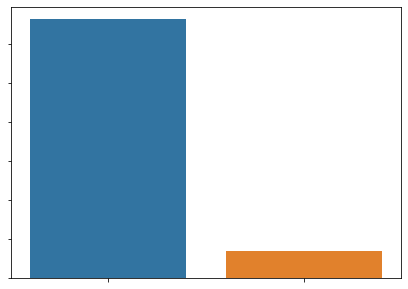

In [806]:
plt.figure(figsize=(7,5))
fig = sns.countplot(x="21", data=cardio_train)
for p in fig.patches:
    height = p.get_height()
    fig.text(p.get_x()+p.get_width()/2., height + 0.5,height ,ha="center")

In [807]:
141/(141+1323)

0.09631147540983606

## build a model

In [808]:
IF_model = IsolationForest(n_estimators=14,max_features=1.0,max_samples=75,random_state=40,contamination=0.099, behaviour='new')
# param_grid = {'n_estimators': list(range(100, 800, 5)), 
#               'max_samples': list(range(100, 500, 5)), 
#               'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
#               'bootstrap': [True, False], 
#               'n_jobs': [5, 10, 20, 30]}
# IF_model = GridSearchCV(IF_model, param_grid ,scoring='average_precision', cv=5)
IF_model.fit(train_data,train_label)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.099,
                max_features=1.0, max_samples=75, n_estimators=14, n_jobs=None,
                random_state=40, verbose=0, warm_start=False)

## average precision score

In [809]:
test_score=IF_model.decision_function(test_data)
#print(test_score)
average_precision = average_precision_score(test_label, -test_score)
print('Average precision-recall score: {0:0.5f}'.format(
      average_precision))

Average precision-recall score: 0.70559


## make predict

In [810]:
result_model=IF_model.predict(test_data)
#report_model=report(test_label,result_model,digits=5)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
#print(result_model)
report_model=report(test_label,result_model,digits=5)
matrix_model=matrix(test_label,result_model)
print(report_model)
print(matrix_model)

              precision    recall  f1-score   support

           0    0.97015   0.97892   0.97451       332
           1    0.78125   0.71429   0.74627        35

    accuracy                        0.95368       367
   macro avg    0.87570   0.84660   0.86039       367
weighted avg    0.95213   0.95368   0.95275       367

[[325   7]
 [ 10  25]]


## plot

isolation: f1=0.746 auc=0.694


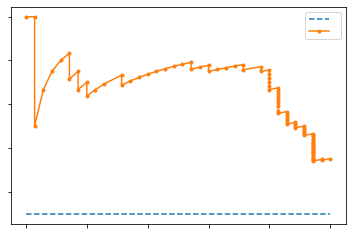

In [811]:
# predict probabilities
lr_probs = IF_model.score_samples(test_data)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# predict class values
result_model = IF_model.predict(test_data)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
lr_precision, lr_recall, _ = precision_recall_curve(test_label, -lr_probs)
lr_f1, lr_auc = f1_score(test_label, result_model), auc(lr_recall, lr_precision)
# summarize scores
print('isolation: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
out_lier = len(test_label[test_label==1]) / len(test_label)
plt.plot([0, 1], [out_lier, out_lier], linestyle='--', label='out_lier')
plt.plot(lr_recall, lr_precision, marker='.', label='isolation')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# Dataset3: creditcard (0.00173)

## load data

In [812]:
credit_train=pd.read_csv('data/credit_train.csv',sep=',')
credit_test=pd.read_csv('data/credit_test.csv',sep=',')

#train_raw_data = http_train.drop(http_train.index[0])
train_data = credit_train.drop(credit_train.columns[[0,-1]],axis='columns')
train_label = credit_train.iloc[:,-1]

#test_raw_data = http_test.drop(http_test.index[0])
test_data = credit_test.drop(credit_test.columns[[0,-1]],axis='columns')
test_label = credit_test.iloc[:,-1]

print(credit_train.iloc[:,-1].value_counts())
#credit_train.shape

0    227451
1       394
Name: Class, dtype: int64


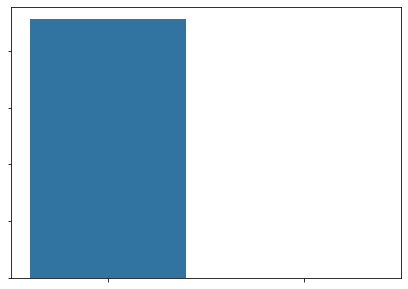

In [813]:
plt.figure(figsize=(7,5))
fig = sns.countplot(x="Class", data=credit_train)
for p in fig.patches:
    height = p.get_height()
    fig.text(p.get_x()+p.get_width()/2., height + 0.5,height ,ha="center")

In [814]:
394/(394+227451)

0.001729245759178389

## build a model

In [815]:
IF_model = IsolationForest(warm_start=True,n_estimators=100,max_features=1,random_state=42,n_jobs=-1,contamination=0.0018, behaviour='new')
# param_grid = {'n_estimators': list(range(100, 800, 5)), 
#               'max_samples': list(range(100, 500, 5)), 
#               'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
#               'bootstrap': [True, False], 
#               'n_jobs': [5, 10, 20, 30]}
# IF_model = GridSearchCV(IF_model, param_grid ,scoring='average_precision', cv=5)
IF_model.fit(train_data,train_label)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.0018,
                max_features=1, max_samples='auto', n_estimators=100, n_jobs=-1,
                random_state=42, verbose=0, warm_start=True)

## average precision score

In [816]:
test_score=IF_model.decision_function(test_data)
print(test_score)
average_precision = average_precision_score(test_label, -test_score)
print('Average precision-recall score: {0:0.5f}'.format(
      average_precision))

[0.15728645 0.10132484 0.07488151 ... 0.14450561 0.16954475 0.16089792]
Average precision-recall score: 0.19001


## make predict

In [817]:
result_model=IF_model.predict(test_data)
#report_model=report(test_label,result_model,digits=5)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
#print(result_model)
report_model=report(test_label,result_model,digits=5)
matrix_model=matrix(test_label,result_model)
print(report_model)
print(matrix_model)

              precision    recall  f1-score   support

           0    0.99887   0.99873   0.99880     56864
           1    0.32075   0.34694   0.33333        98

    accuracy                        0.99761     56962
   macro avg    0.65981   0.67284   0.66607     56962
weighted avg    0.99771   0.99761   0.99766     56962

[[56792    72]
 [   64    34]]


isolation: f1=0.333 auc=0.186


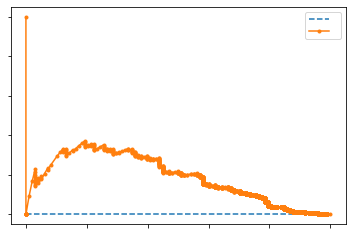

In [818]:
# predict probabilities
lr_probs = IF_model.score_samples(test_data)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# predict class values
result_model = IF_model.predict(test_data)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
lr_precision, lr_recall, _ = precision_recall_curve(test_label, -lr_probs)
lr_f1, lr_auc = f1_score(test_label, result_model), auc(lr_recall, lr_precision)
# summarize scores
print('isolation: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
out_lier = len(test_label[test_label==1]) / len(test_label)
plt.plot([0, 1], [out_lier, out_lier], linestyle='--', label='out_lier')
plt.plot(lr_recall, lr_precision, marker='.', label='isolation')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# Separate 10% of trainning data set

In [819]:
credit_train=pd.read_csv('data/credit_train.csv',sep=',')
credit_test=pd.read_csv('data/credit_test.csv',sep=',')
# only choose 10% tranning dataset
credit_train= credit_train.drop(credit_train.columns[[0]],axis='columns')
credit_test= credit_test.drop(credit_test.columns[[0]],axis='columns')
#credit_train= credit_train.loc[credit_train['Class'] == 0]

#train_raw_data = http_train.drop(http_train.index[0])
train_label = credit_train.iloc[:,-1]
test_label = credit_test.iloc[:,-1]


inner_liers=credit_train[train_label==0]
outter_liers=credit_train[train_label==1]
#outter_liers.head()
from sklearn.model_selection import ShuffleSplit
rs=ShuffleSplit(n_splits=1, random_state=42, test_size=0.10)
for train_index, test_index in rs.split(inner_liers):
    inner_liers=inner_liers.iloc[test_index]
    
frames=[inner_liers,outter_liers]
credit_train=pd.concat(frames)

# for test set
inner_liers=credit_test[test_label==0]
outter_liers=credit_test[test_label==1]
#outter_liers.head()
from sklearn.model_selection import ShuffleSplit
rs=ShuffleSplit(n_splits=1, random_state=42, test_size=0.10)
for train_index, test_index in rs.split(inner_liers):
    inner_liers=inner_liers.iloc[test_index]
    
frames=[inner_liers,outter_liers]
credit_test=pd.concat(frames)


# train_data = np.concatenate((inner_liers, outter_liers), axis=1)

# train_data = pd.DataFrame(train_data)
#outter_liers.head()

#test_raw_data = http_test.drop(http_test.index[0])
# test_data = credit_test.drop(credit_test.columns[-1],axis='columns')
# test_label = credit_test.iloc[:,-1]


train_data = credit_train.drop(credit_train.columns[-1],axis='columns')
train_label = credit_train.iloc[:,-1]

test_data = credit_test.drop(credit_test.columns[-1],axis='columns')
test_label = credit_test.iloc[:,-1]
# print(train_data.head())
# print(test_data.head())
# #train_data.head()
# credit_train.shape
dirname = "data/"

# Change filenames according to dataset
# credit_train.to_csv(dirname + "credit_train_reduced.csv", index=False)
# credit_test.to_csv(dirname + "credit_test_reduced.csv", index=False)

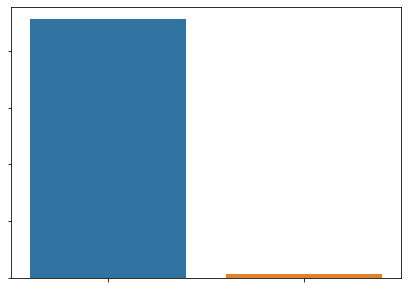

In [820]:
plt.figure(figsize=(7,5))
fig = sns.countplot(x="Class", data=credit_train)
for p in fig.patches:
    height = p.get_height()
    fig.text(p.get_x()+p.get_width()/2., height + 0.5,height ,ha="center")

In [821]:
394/(394+22746)

0.017026793431287813

# build a model

In [822]:
IF_model = IsolationForest(n_estimators=130,max_features=0.63,max_samples=256,random_state=42,n_jobs=-1,contamination=0.01802679, behaviour='new')
# param_grid = {'n_estimators':[50,100,150] 
#               }
#               'max_samples': list(range(100, 500, 5)), 
#               'contamination': [0.1, 0.2, 0.3, 0.4, 0.5], 
#               'bootstrap': [True, False], 
#               'n_jobs': [5, 10, 20, 30]
# IF_model = GridSearchCV(IF_model, param_grid ,scoring='average_precision', cv=5)
IF_model.fit(train_data,train_label)

IsolationForest(behaviour='new', bootstrap=False, contamination=0.01802679,
                max_features=0.63, max_samples=256, n_estimators=130, n_jobs=-1,
                random_state=42, verbose=0, warm_start=False)

## average precision score

In [823]:
test_score=IF_model.decision_function(test_data)
print(test_score)
average_precision = average_precision_score(test_label, -test_score)
print('Average precision-recall score: {0:0.5f}'.format(
      average_precision))

[0.12277716 0.16307763 0.18123878 ... 0.15151577 0.11879801 0.09194772]
Average precision-recall score: 0.60894


## make predict

In [824]:
result_model=IF_model.predict(test_data)
#report_model=report(test_label,result_model,digits=5)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
#print(result_model)
report_model=report(test_label,result_model,digits=5)
matrix_model=matrix(test_label,result_model)
print(report_model)
print(matrix_model)

              precision    recall  f1-score   support

           0    0.99296   0.99156   0.99226      5687
           1    0.54717   0.59184   0.56863        98

    accuracy                        0.98479      5785
   macro avg    0.77006   0.79170   0.78044      5785
weighted avg    0.98540   0.98479   0.98508      5785

[[5639   48]
 [  40   58]]


## plot

isolation: f1=0.569 auc=0.607


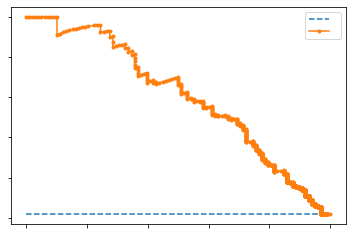

In [825]:
# predict probabilities
lr_probs = IF_model.score_samples(test_data)
# keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# predict class values
result_model = IF_model.predict(test_data)
for i in range(len(result_model)):
    if(result_model[i]==-1):
        result_model[i]=1
    else:
        result_model[i]=0
lr_precision, lr_recall, _ = precision_recall_curve(test_label, -lr_probs)
lr_f1, lr_auc = f1_score(test_label, result_model), auc(lr_recall, lr_precision)
# summarize scores
print('isolation: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
out_lier = len(test_label[test_label==1]) / len(test_label)
plt.plot([0, 1], [out_lier, out_lier], linestyle='--', label='out_lier')
plt.plot(lr_recall, lr_precision, marker='.', label='isolation')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()